In [1]:
import pandas as pd
import scipy.stats
import seaborn as sns
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim
from torch import tensor


from beanmachine.ppl.experimental.tests.vi.vi_test import NealsFunnel
from beanmachine.ppl.experimental.vi.variational_infer import VariationalApproximation


sns.set_style("darkgrid")

Define Neal's Funnel where $p(x,y) = N(y|0,3) N(x|0,\exp(y/2))$.

In [2]:
nf = NealsFunnel()

Visualize the PDF of Neal's funnel on a grid

<ipython-input-3-74872adbad04>:1: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  xs = torch.linspace(-6, 6)


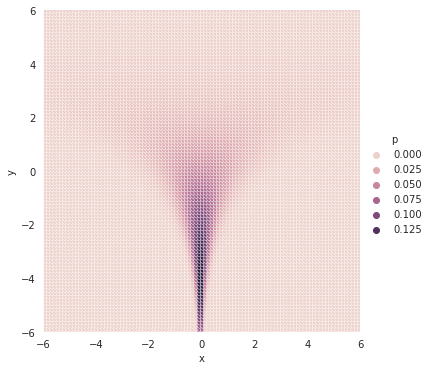

In [3]:
xs = torch.linspace(-6, 6)
ys = torch.linspace(-6, 6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = nf.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).numpy(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6, 6],
    ylim=[-6, 6],
)

Draw some samples from Neal's funnel and plot a KDE

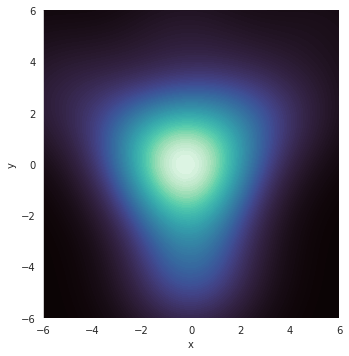

In [4]:
vi_samples = nf.sample((100,)).detach().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": vi_samples[:, 0],
        "y": vi_samples[:, 1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6, 6],
    ylim=[-6, 6],
)

In [5]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": nf_samples[:, 0],
        "y": nf_samples[:, 1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6, 6],
    ylim=[-6, 6],
)

NameError: name 'nf_samples' is not defined

Fit an IAF to this density

In [ ]:
vi = VariationalApproximation(
    base_dist=dist.MultivariateNormal,
    base_args={
        'loc': torch.zeros(2),
        'covariance_matrix': torch.eye(2),
    }).train(epochs=1000, target_log_prob=nf.log_prob)

Compare samples from the IAF

In [ ]:
vi_samples = vi.sample((100,)).detach().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": vi_samples[:, 0],
        "y": vi_samples[:, 1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6, 6],
    ylim=[-6, 6],
)

In [ ]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": vi_samples[:, 0],
        "y": vi_samples[:, 1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6, 6],
    ylim=[-6, 6],
)

In [ ]:
xs = torch.linspace(-6, 6)
ys = torch.linspace(-6, 6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = vi.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy().flatten(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6, 6],
    ylim=[-6, 6],
)

Are they close? Measure in K-S distance

In [ ]:
print(
    scipy.stats.ks_2samp(nf_samples[:, 0], vi_samples[:, 0]).pvalue,
    scipy.stats.ks_2samp(nf_samples[:, 1], vi_samples[:, 1]).pvalue,
)

## To compare, lets consider fitting a GMM to Neal's funnel using inclusive KL

In [ ]:
K = 7
mix = torch.ones(K) / K
mu = nn.Parameter(torch.randn(K,2))
sigma = nn.Parameter(torch.abs(torch.randn(K,2)))

optim = torch.optim.Adam([
    mu, sigma
], lr=1e-2)

for _ in range(100):
    optim.zero_grad()
    x = nf.sample((100,))
    gmm = dist.MixtureSameFamily(
        dist.Categorical(logits=mix),
        dist.Independent(
            dist.Normal(mu, sigma),
            1))
    loss = -gmm.log_prob(x).sum()
    loss.backward()
    optim.step()

gmm = dist.MixtureSameFamily(
    dist.Categorical(logits=mix),
    dist.Independent(
        dist.Normal(mu, sigma),
        1))
xs = torch.linspace(-3, 3)
ys = torch.linspace(-3, 3)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = gmm.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")

## Now let's consider fitting a GMM with an IAF

In [ ]:
def gmm(x):
    return torch.log(
        0.5*torch.exp(dist.MultivariateNormal(
            torch.tensor([-2, -1]),
            0.5*torch.eye(2)
        ).log_prob(x))
        + 0.5*torch.exp(dist.MultivariateNormal(
            torch.tensor([1, 2]),
            0.5*torch.eye(2)
        ).log_prob(x)))


vi = VariationalApproximation(
    base_dist=dist.MultivariateNormal,
    base_args={'loc': nn.Parameter(torch.zeros(2)),
               'covariance_matrix': torch.eye(2),
              },
    lr=1e-1).train(epochs=500, target_log_prob=gmm)

In [ ]:
xs = torch.linspace(-3, 3)
ys = torch.linspace(-3, 3)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = vi.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")

Compare against ground truth

In [ ]:
xs = torch.linspace(-3, 3)
ys = torch.linspace(-3, 3)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = gmm(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")

# Investigate heavy-tailed base distribution

Try fitting a (heavy-tailed) using a light-tailed IAF (normal base distribution) versus heavy-tailed IAF (StudentT base distribution)

In [ ]:
target = dist.Cauchy(-2, 1)

vi_normal = VariationalApproximation(
    base_dist=dist.Normal,
    base_args={'loc': nn.Parameter(tensor(0.0)),
               'scale': tensor(1.0)},
    lr=1e-1).train(epochs=300, target_log_prob=target.log_prob)

vi_student = VariationalApproximation(
    base_dist=dist.StudentT,
    base_args={
        'df': nn.Parameter(tensor(0.1)),
        'loc': tensor(0.0),
        'scale': tensor(1.0),
    },
    lr=1e-1).train(epochs=300, target_log_prob=target.log_prob)

In [ ]:
x = torch.linspace(-5, 5).unsqueeze(1)
p_truth = torch.exp(target.log_prob(x))
p_normal = torch.exp(vi_normal.log_prob(x))
p_student = torch.exp(vi_student.log_prob(x))
sns.relplot(data=pd.DataFrame({
    "x": x.flatten().detach().numpy(),
    "p_truth": p_truth.flatten().detach().numpy(),
    "p_normal": p_normal.flatten().detach().numpy(),
    "p_student": p_student.flatten().detach().numpy(),
}).melt(id_vars=["x"]), x="x", y="value", hue="variable", kind="line")

In [ ]:
vi_student.flow_stack.base_dist(**vi_student.flow_stack.base_args)

In [ ]:
g = sns.distplot([scipy.stats.ks_2samp(
    target.sample((100,)).detach().flatten(),
    vi_normal.sample((100,)).detach().flatten(),
).pvalue for _ in range(1000)])
g.set(xlim=[0, 1])

In [ ]:
g = sns.distplot([scipy.stats.ks_2samp(
    target.sample((100,)).detach().flatten(),
    vi_student.sample((100,)).detach().flatten(),
).pvalue for _ in range(1000)])
g.set(xlim=[0, 1])